# Modelo Árboles de decisión y clasificación (CART)

Referencia: https://www.kaggle.com/datasets/iamhungundji/covid19-symptoms-checker

# Dataset: COVID-19 Symptoms Checker

# Descripción

Estos datos ayudarán a identificar si alguna persona tiene una enfermedad por coronavirus o no en función de algunos síntomas estándar predefinidos. Estos síntomas se basan en las pautas proporcionadas por la Organización Mundial de la Salud (OMS)who.int y el Ministerio de Salud y Bienestar Familiar de la India.

# Cargar los datos

In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [ ]:
# https://www.kaggle.com/datasets/iamhungundji/covid19-symptoms-checker
# Desarrollar el ejercicio propuesto implementando la regresión logística
datos = pd.read_csv('./Datos/Cleaned-Data.csv')

In [ ]:
datos.head(10)

## Variables de interes:
* Fever
* Tiredness
* Dry-Cough
* Difficulty-in-Breathing
* Sore-Throat
* None_Sympton
* Pains
* Nasal-Congestion
* Runny-Nose
* Diarrhea

## Revisión de los datos

In [7]:
datos[['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing', 'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea']].head(10)

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea
0,1,1,1,1,1,0,1,1,1,1
1,1,1,1,1,1,0,1,1,1,1
2,1,1,1,1,1,0,1,1,1,1
3,1,1,1,1,1,0,1,1,1,1
4,1,1,1,1,1,0,1,1,1,1
5,1,1,1,1,1,0,1,1,1,1
6,1,1,1,1,1,0,1,1,1,1
7,1,1,1,1,1,0,1,1,1,1
8,1,1,1,1,1,0,1,1,1,1
9,1,1,1,1,1,0,1,1,1,1


## Función logística

Se ajusta un árbol de clasificación empleando como variable respuesta `datos`  y como predictores todas las variables disponibles. Se utilizan en primer lugar los hiperparámetros `max_depth=5` y `criterion='gini'` , el resto se dejan por defecto. Después, se aplica el proceso de pruning y se comparan los resultados frente al modelo inicial.

In [10]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'Fever'),
                                        datos['Fever'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [11]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237600 entries, 0 to 237599
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Tiredness                   237600 non-null  float64
 1   Dry-Cough                   237600 non-null  float64
 2   Difficulty-in-Breathing     237600 non-null  float64
 3   Sore-Throat                 237600 non-null  float64
 4   None_Sympton                237600 non-null  float64
 5   Pains                       237600 non-null  float64
 6   Nasal-Congestion            237600 non-null  float64
 7   Runny-Nose                  237600 non-null  float64
 8   Diarrhea                    237600 non-null  float64
 9   None_Experiencing           237600 non-null  float64
 10  Age_0-9                     237600 non-null  float64
 11  Age_10-19                   237600 non-null  float64
 12  Age_20-24                   237600 non-null  float64
 13  Age_25-59     

In [12]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 21


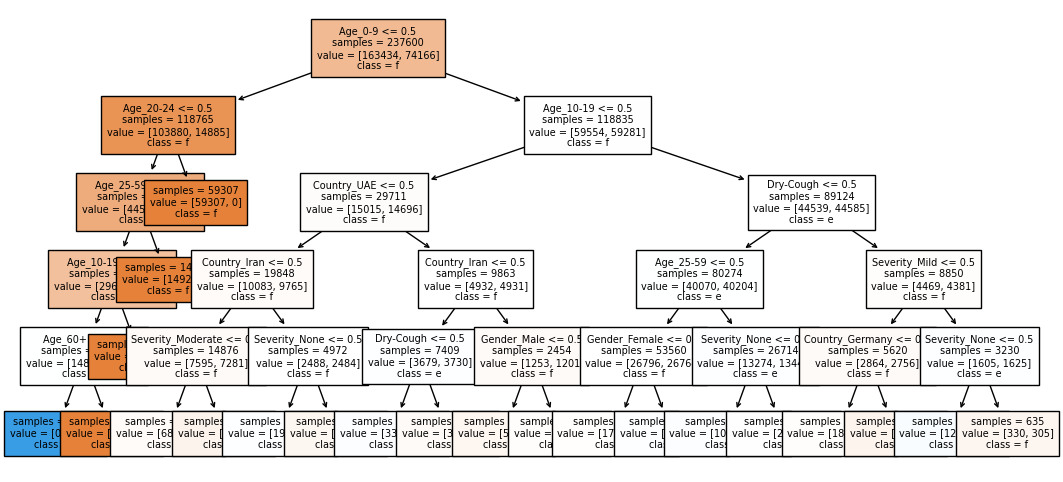

In [13]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'fever_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

## Predicción y evaluación del modelo

Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.

In [14]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[45172,  9194],
       [11150, 13684]], dtype=int64)

In [15]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 74.31313131313131 %


## Podado del árbol (pruning)

Aunque inicialmente se ha empleado un valor de max_depth=5, este no tiene por qué ser el mejor valor. Con el objetivo de identificar la profundidad óptima que consigue reducir la varianza y aumentar la capacidad predictiva del modelo, se somete al árbol a un proceso de pruning.

In [ ]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_prep, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [ ]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

In [ ]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

## Importancia de predictores

In [ ]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': labels.tolist(),
                             'importancia': modelo_final.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

## Predicción de probabilidades

In [ ]:
# Predicción de probabilidades
#-------------------------------------------------------------------------------
predicciones = modelo.predict_proba(X = X_test_prep)
predicciones[:5, :]

In [ ]:
# Clasificación empleando la clase de mayor probabilidad
# ------------------------------------------------------------------------------
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

In [ ]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ------------------------------------------------------------------------------
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.8, 1, 0)
df_predicciones.iloc[5:10, :]